In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import cv2
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm
import warnings

In [2]:
import os

# Define paths
dataset_path = '/kaggle/input/date-palm-data/Date Palm data/'

# List all directories in the 'Date Palm data' folder
all_dirs = os.listdir(dataset_path)
print(f"Directories in dataset path: {all_dirs}")

# If class folders are subdirectories, filter only directories
classes = [d for d in all_dirs if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Classes found: {classes}")

# Count images in each class
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    image_count = len(os.listdir(class_path))
    print(f"Train {cls}: {image_count} images")


Directories in dataset path: ['brown spots', 'healthy', 'white scale']
Classes found: ['brown spots', 'healthy', 'white scale']
Train brown spots: 470 images
Train healthy: 1203 images
Train white scale: 958 images


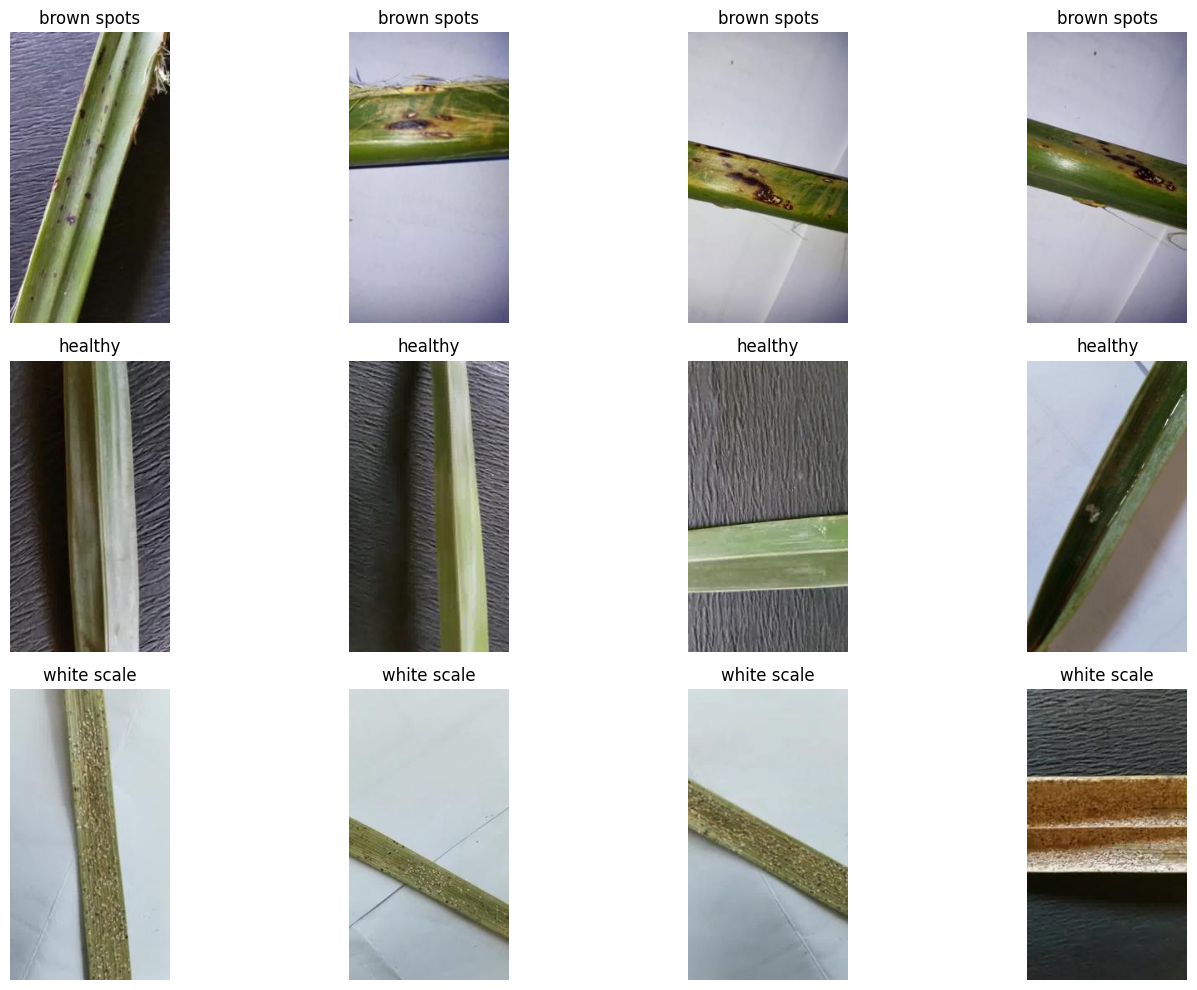

In [3]:
# Function to show sample images
def show_samples(path, num_samples=4):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        images = os.listdir(class_path)[:num_samples]
        
        for j, img_name in enumerate(images):
            img = Image.open(os.path.join(class_path, img_name))
            plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show train samples
show_samples(dataset_path)

Image dimensions summary:
            width      height
count   30.000000   30.000000
mean   197.266667  344.733333
std     28.846721   28.846721
min    192.000000  192.000000
25%    192.000000  350.000000
50%    192.000000  350.000000
75%    192.000000  350.000000
max    350.000000  350.000000


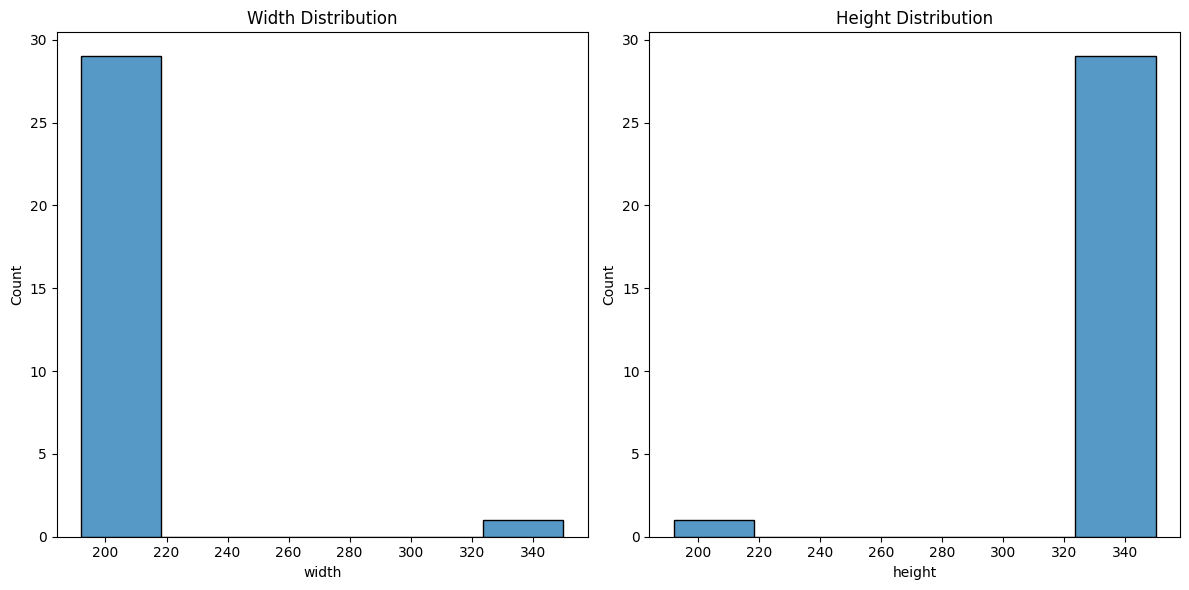

In [4]:
# Suppress all warnings 
warnings.filterwarnings('ignore')
# Check image dimensions
def check_dimensions(path):
    dimensions = []
    for cls in classes:
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path)[:10]:  # Check first 10 images
            img = Image.open(os.path.join(class_path, img_name))
            dimensions.append(img.size)
    
    return pd.DataFrame(dimensions, columns=['width', 'height'])

dim_df = check_dimensions(dataset_path)
print("Image dimensions summary:")
print(dim_df.describe())

# Plot dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dim_df['width'])
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dim_df['height'])
plt.title('Height Distribution')
plt.tight_layout()
plt.show()

In [5]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define paths
dataset_path = '/kaggle/input/date-palm-data/Date Palm data/'
output_base_path = '/kaggle/working/date_palm_processed'

# Create output directories
augmented_dir = os.path.join(output_base_path, 'augmented')
test_path = os.path.join(output_base_path, 'test')
os.makedirs(augmented_dir, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set image size for EfficientNetB0
IMG_SIZE = (224, 224)

# Data augmentation with EfficientNetB0 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    rotation_range=20,        # Add rotation for variety
    width_shift_range=0.2,    # Add width shift
    height_shift_range=0.2,   # Add height shift
    fill_mode='nearest',      # Fill empty pixels
    validation_split=0.2      # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Function to split dataset and create test set
def split_dataset(source_dir, augmented_dir, test_dir, test_ratio=0.1):
    # Get all classes
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    for cls in classes:
        # Create class directories
        os.makedirs(os.path.join(augmented_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        
        # Get all images for this class
        class_path = os.path.join(source_dir, cls)
        images = os.listdir(class_path)
        
        # Shuffle images
        random.shuffle(images)
        
        # Calculate test split
        test_count = int(len(images) * test_ratio)
        
        # Split images
        for i, img_name in enumerate(images):
            src_path = os.path.join(class_path, img_name)
            
            if i < test_count:
                # Move to test set
                dst_path = os.path.join(test_dir, cls, img_name)
            else:
                # Move to augmentation set
                dst_path = os.path.join(augmented_dir, cls, img_name)
            
            shutil.copy(src_path, dst_path)

# Function to create the data generator
def create_generator(directory, datagen, subset=None):
    return datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        subset=subset
    )

# Step 1: Pre-generate augmented images to reach 500 per class
def augment_to_target(source_dir, target_dir, target_count=500):
    # Get all classes in the source directory
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    for cls in classes:
        src_cls_dir = os.path.join(source_dir, cls)
        aug_cls_dir = os.path.join(target_dir, cls)
        
        # Calculate how many more images are needed
        current_count = len(os.listdir(src_cls_dir))
        aug_needed = target_count - current_count
        
        print(f"Augmenting {cls}: {current_count} -> {target_count} (+{aug_needed})")
        
        i = 0
        img_list = os.listdir(src_cls_dir)
        while i < aug_needed:
            img_name = img_list[i % len(img_list)]  # Cycle through original images
            img_path = os.path.join(src_cls_dir, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension
            
            # Generate one augmented image
            for batch in train_datagen.flow(img_array, batch_size=1):
                aug_img = batch[0]  # Already preprocessed by preprocess_input
                save_img(os.path.join(aug_cls_dir, f'aug_{i}_{img_name}'), aug_img)
                i += 1
                break  # One image per iteration

# Main execution
if __name__ == '__main__':
    # Step 1: Split dataset into augmentation and test sets
    split_dataset(dataset_path, augmented_dir, test_path)

    # Step 2: Run augmentation on augmentation set
    augment_to_target(augmented_dir, augmented_dir)

    # Step 3: Create generators
    train_generator = create_generator(augmented_dir, train_datagen, subset='training')
    validation_generator = create_generator(augmented_dir, train_datagen, subset='validation')
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical'
    )

    # Verify generator outputs
    print(f"Train samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    print(f"Test samples: {test_generator.samples}")

Augmenting healthy: 1083 -> 500 (+-583)
Augmenting white scale: 863 -> 500 (+-363)
Augmenting brown spots: 423 -> 500 (+77)
Found 1958 images belonging to 3 classes.
Found 488 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Train samples: 1958
Validation samples: 488
Test samples: 262


# **CUSTOM CNN**

In [6]:

def plot_training_history(history, model_name='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the CNN model
model_2 = Sequential()

# Convolutional Block 1
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model_2.add(BatchNormalization())  # Keep BatchNorm only after the first Conv layer
model_2.add(MaxPooling2D((2, 2)))

# Convolutional Block 2
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2)))

# Convolutional Block 3
model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2)))

# Global Pooling and Dense Layers
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))  # Reduce L2
model_2.add(Dropout(0.4))  # Slightly reduce dropout
model_2.add(Dense(train_generator.num_classes, activation='softmax'))  # 4 classes

# Optimizer with a Warmup Strategy
opt = Adam(learning_rate=0.001)  # Start with higher LR

# Compile the model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 443ms/step - accuracy: 0.5012 - loss: 1.0260 - val_accuracy: 0.2480 - val_loss: 3.5187 - learning_rate: 0.0010
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - accuracy: 0.7274 - loss: 0.6403 - val_accuracy: 0.6578 - val_loss: 0.7080 - learning_rate: 0.0010
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.8085 - loss: 0.5196 - val_accuracy: 0.5943 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 372ms/step - accuracy: 0.8355 - loss: 0.4542 - val_accuracy: 0.8053 - val_loss: 0.7572 - learning_rate: 0.0010
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.8762 - loss: 0.3618 - val_accuracy: 0.7152 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.8722 - loss: 0.3616 - val_accuracy: 0.6742 - val_loss: 1.2339 - learning_rate: 0.0010
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.8998 - loss: 0.

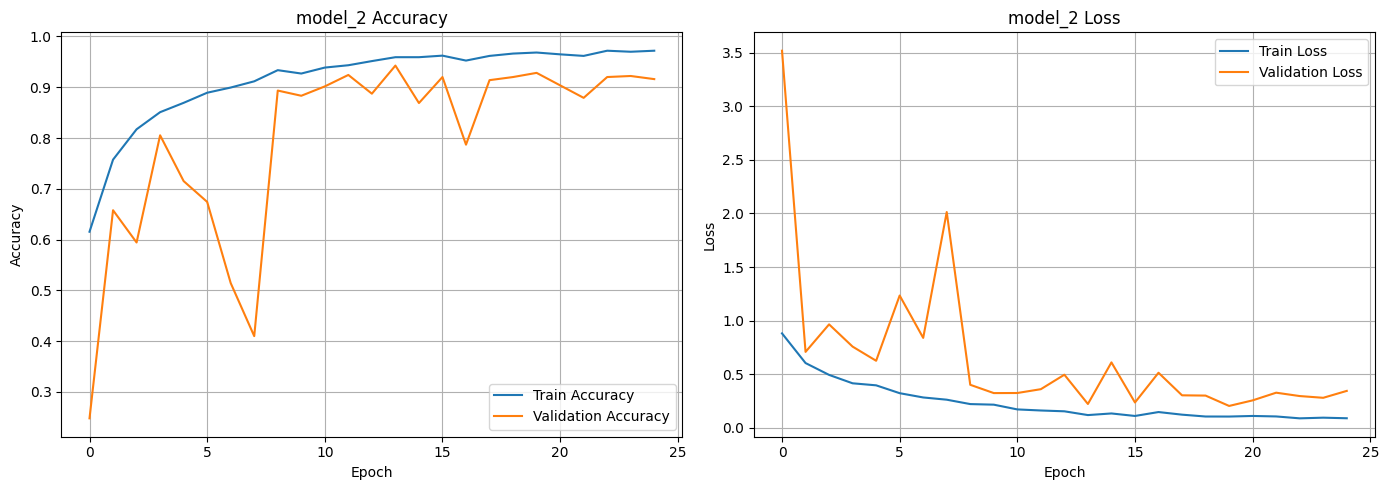

In [8]:
# Train the model
history = model_2.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Call the function
plot_training_history(history, model_name='model_2')

# **EFFICIENTNET B1**

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 92s 874ms/step - accuracy: 0.3015 - loss: 1.8496 - val_accuracy: 0.4303 - val_loss: 1.6570 - learning_rate: 1.0000e-05
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.3741 - loss: 1.7267 - val_accuracy: 0.6045 - val_loss: 1.5653 - learning_rate: 1.0000e-05
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.4286 - loss: 1.6600 - val_accuracy: 0.6762 - val_loss: 1.4889 - learning_rate: 1.0000e-05
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.4977 - loss: 1.5669 - val_accuracy: 0.7725 - val_loss: 1.4306 - learning_rate: 1.0000e-05
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.5614 - loss: 1.5065 - val_accuracy: 0.8115 - val_loss: 1.3620 - learning_rate: 1.0000e-05
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 373ms/step - accuracy: 0.6553 - loss: 1.4208 - val_accuracy: 0.8525 - val_loss: 1.3000 - learning_rate: 1.0000e-05
Epoch 7

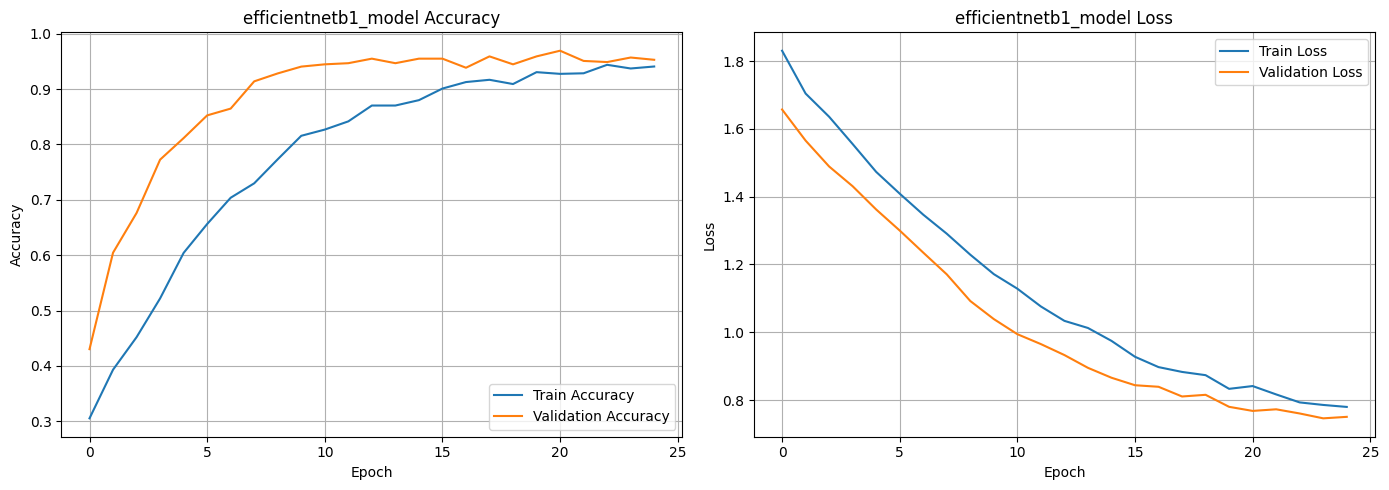

In [22]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load EfficientNetB1
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the base model
for layer in base_model.layers[:-30]:  # fine-tune last 30 layers
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create model
effnetb1_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
opt = Adam(learning_rate=1e-5)
effnetb1_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
historyEFFB1 = effnetb1_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
test_loss, test_acc = effnetb1_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot
plot_training_history(historyEFFB1, model_name='efficientnetb1_model')


# **EFFICIENTNET B0**

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 69s 724ms/step - accuracy: 0.3657 - loss: 1.9309 - val_accuracy: 0.4385 - val_loss: 1.8647 - learning_rate: 1.0000e-05
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.4538 - loss: 1.8599 - val_accuracy: 0.5553 - val_loss: 1.7975 - learning_rate: 1.0000e-05
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.5266 - loss: 1.7757 - val_accuracy: 0.6762 - val_loss: 1.7124 - learning_rate: 1.0000e-05
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - accuracy: 0.6198 - loss: 1.6906 - val_accuracy: 0.7602 - val_loss: 1.6379 - learning_rate: 1.0000e-05
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 362ms/step - accuracy: 0.6698 - loss: 1.6292 - val_accuracy: 0.8463 - val_loss: 1.5729 - learning_rate: 1.0000e-05
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.7399 - loss: 1.5468 - val_accuracy: 0.8648 - val_loss: 1.5124 - learning_rate: 1.0000e-05
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 361ms/step - acc

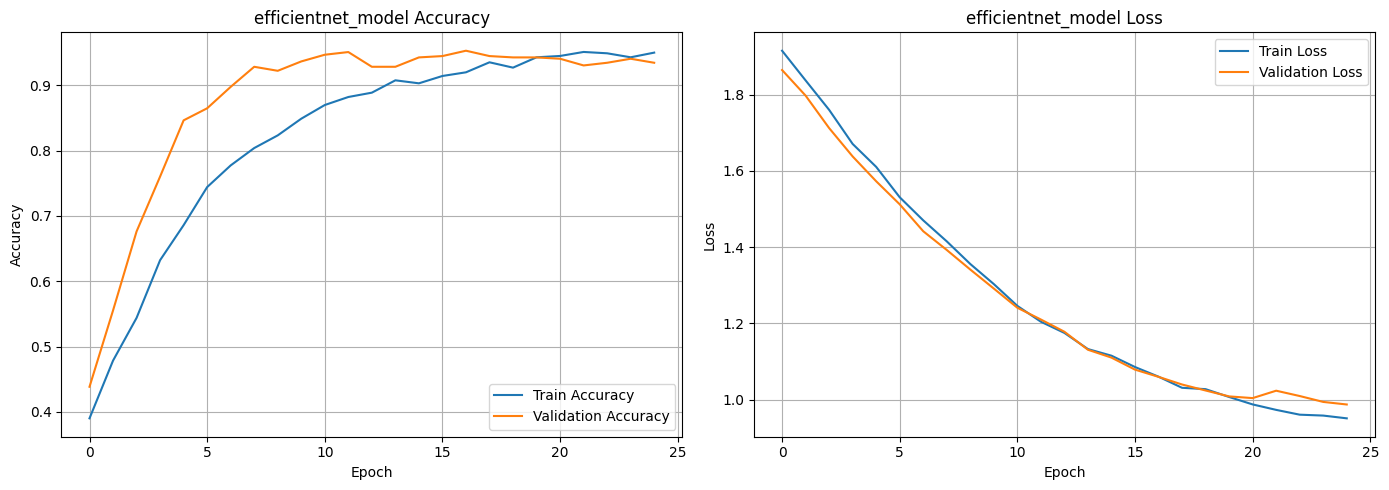

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the base model layers, fine-tune more layers
for layer in base_model.layers[:-30]:   # fine-tune last 30 layers, not just 10
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0015))(x)  # slightly lower regularization
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create model
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile with smaller initial learning rate
opt = Adam(learning_rate=1e-5)  # start lower!
efficientnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model
historyEFF = efficientnet_model.fit(
    train_generator,
    epochs=25,  # You can train more epochs because learning rate is safer
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
test_loss, test_acc = efficientnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot
plot_training_history(historyEFF, model_name='efficientnet_model')
